# CASA0013 FSDS Assignment 3: Data-Led Executive Briefing

In [9]:
# Import required packages

import numpy as np
import pandas as pd
import geopandas as gpd
import re
import math

## Proxy 1: Proportion of Total Residential Rent Generated from Airbnb

### Airbnb data for 2020

Define functions for scalability
- Read and clean Airbnb data
- Compute estimated occupancy

In [2]:
# Define function to read and clean Airbnb data

def load_airbnb(date_scraped):
    
    '''
    Load and clean Airbnb data

    :param date_scraped: date where Airbnb data is scrapped in yyyymmdd in string format
    :return: cleaned up geopandas dataframe
    '''
    
    # Compose url and print message
    print(f'Loading and cleaning Airbnb data for {date_scraped}')
    url = 'https://github.com/ngliangwei15/CASA0013-Assignment3/blob/main/listings-' + (
    date_scraped + '.csv.gz?raw=true')
    
    # Define columns to read in
    cols = ['id', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews_ltm']

    # Load data
    df = pd.read_csv(url, usecols=cols, compression='gzip',low_memory=False)
    print(f'{df.shape[0]} listings were loaded.')
    
    # Remove inactive listing - no listing within last 12 months.
    df.drop(df[df['number_of_reviews_ltm'] == 0].index, axis=0, inplace=True)
    print(f'{df.shape[0]} listings were left after removing inactive listings.')
    
    # Keep only entire place listings
    df.drop(df[df['room_type'] != 'Entire home/apt'].index, axis=0, inplace=True)
    print(f'{df.shape[0]} listings were left after keeping only entire home/apt listings.')
    
    # Clean the price data
    df['price'] = df.price.str.replace('$','').str.replace(',','').astype(float)
    
    # Convert dataframe into geodataframe
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']), crs='epsg:4326')
    gdf = gdf.to_crs('epsg:27700')
    
    # return cleaned gdf
    return gdf

In [14]:
# Define function to estimate occupancy using the occupancy model, and compute the income from Airbnb

def occupancy_model(df, review_rate = 0.5, average_occupancy = 5.3, occupancy_cap = 0.7):
    
    '''
    Compute the estimated occupancy of each listing in the past yearusing the occupancy model

    :param gdf: dataframe of Airbnb data
    :return: dataframe with occupancy computed
    '''
    # Compute estimated number of bookings
    df['est_bookings'] = df['number_of_reviews_ltm'] / review_rate
    
    # Compute estimated nights of occupancy
    df['est_occupancy'] = df['est_bookings'] * average_occupancy
    df['est_occupancy'] = df['est_occupancy'].apply(np.ceil)
    
    # If listing has higher minimum number of nights, update estimated nights of occupancy
    df['est_occupancy'] = df[['minimum_nights','est_occupancy']].max(axis = 1)
    
    # Cap occupancy rate at 70% of the nights in a year
    df.loc[(df['est_occupancy'] > (occupancy_cap * 365)), ['est_occupancy']] = math.floor(occupancy_cap * 365)
    
    df['airbnb_income'] = df['price'] * df['est_occupancy']
    
    # return dataframe with occupancy computed for each listing
    return df

Read 2020 data

In [163]:
# Load Airbnb data scraped on 16 Dec 2020
date_scraped = '20201216'
airbnb_2020 = load_airbnb(date_scraped)

Loading and cleaning Airbnb data for 20201216
77136 listings were loaded.
26672 listings were left after removing inactive listings.
16031 listings were left after keeping only entire home/apt listings.


/tmp/ipykernel_4517/27761743.py:32: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['price'] = df.price.str.replace('$','').str.replace(',','').astype(float)


In [164]:
# Compute estimated occupancy
airbnb_2020 = occupancy_model(airbnb_2020)

### Private rental data for 2020

Number of households in private rental in 2020

In [165]:
# Read in data
url = 'https://github.com/ngliangwei15/CASA0013-Assignment3/blob/main/tenure-households-borough.xlsx?raw=true'
rental_households = pd.read_excel(url, sheet_name = '2020')

# Rename and keep only useful columns
rental_households.rename({' ': 'Area Code', 'Unnamed: 1': 'Area', 'Unnamed: 5': 'Households'},
                         axis = 1, inplace = True)
rental_households = rental_households[['Area Code', 'Area', 'Households']]

# Keep only data on London boroughs (Area Code starts with E09) and London
rental_households.dropna(axis = 0, inplace = True)
rental_households = (
rental_households[rental_households['Area Code'].str.match(r'E09')|rental_households['Area'].str.match(r'London')])
    
# Replace suppressed data with 0
rental_households = rental_households.replace({'-': 0})

# Estimate number of households in City of London
rental_households.loc[(rental_households.Area == 'City of London'), ['Households']] = (
    rental_households[rental_households.Area == 'London'].Households.values - 
    sum(rental_households[rental_households.Area != 'London'].Households))

# Drop data for London
rental_households.drop(rental_households[rental_households.Area == 'London'].index, inplace = True)

Define function to read in rental rate data for scalability

In [85]:
# Define function to load and clean private rental rate data

def load_rental(year, sheet):
    
    '''
    Load and clean the data on private rental

    :param year: year of data
    :param sheet: sheet name for property type
    :return: cleaned up pandas dataframe
    '''
    
    # Set number of footers to skip
    if sheet == 'Table2.2':
        footer = 36  # 36 for studio
    else:
        footer = 37  # 37 for all other property type
    
    # Read data
    url = 'https://github.com/ngliangwei15/CASA0013-Assignment3/blob/main/privaterentalmarketstatistics'+ (
        year + '.xls?raw=true')
    df = pd.read_excel(url, sheet_name = sheet, skiprows = 6, skipfooter = footer)
    
    # Drop unused columns
    df.drop(columns = ['Unnamed: 0', 'LA Code1'], inplace = True)
    
    # Keep only data on London boroughs (Area Code starts with E09)
    df = df[df['Area Code1'].str.match(r'E09')].sort_values(by = ['Area Code1'], ascending=True)
    
    # Replace suppressed data with 0
    df = df.replace({'-': 0,
                     '.': 0,
                     '..': 0})
    
    # return cleaned df
    return df.reset_index(drop = True)

Rental rate in 2020

In [166]:
# Year
year = '2020'

# Dictionary for property type and sheet name
prop_sheet = {'studio': 'Table2.2',
              '1br': 'Table2.3',
              '2br': 'Table2.4',
              '3br': 'Table2.5',
              '4br': 'Table2.6'}

# Read data for each property type
for prop, sheet in prop_sheet.items():
    globals()['rental_' + prop] = load_rental(year, sheet)

In [167]:
# Compute average of median rental price, weighted by the count of rents

## Initialize dataframe
rental2020_median = rental_studio[['Area Code1', 'Area']]

## Add two columns - one to track total counts, one to track product of counts and median rental
rental2020_median = rental2020_median.reindex(columns = [*rental2020_median.columns.tolist(),
                                                         'Counts','Median'], fill_value = 0)

## Add counts, and product of counts and median rental, for all property types
for prop in prop_sheet.keys():
    ## Add counts
    rental2020_median.Counts = rental2020_median.Counts + globals()['rental_' + prop]['Count of rents']
    ## Add product of counts and median rental
    rental2020_median.Median = rental2020_median.Median + (
        (globals()['rental_' + prop]['Count of rents'] * globals()['rental_' + prop]['Median']))

## Compute average of median rent
rental2020_median.Median = rental2020_median.Median / rental2020_median.Counts

### London boroughs

In [168]:
# Read boundaries
url = 'https://github.com/ngliangwei15/CASA0013-Assignment3/blob/main/statistical-gis-boundaries-london.gpkg?raw=true'
boros = gpd.read_file(url)
boros = boros.to_crs('epsg:27700')

# Keep only useful columns
boros = boros[['NAME', 'GSS_CODE', 'geometry']]

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


### Join and map proxy

Compute total income from Airbnb for each borough

In [169]:
# Join Airbnb listings to boroughs
airbnb_2020_boros = gpd.sjoin(airbnb_2020, boros, op = 'within', how = 'left')

# Drop listings with no borough names (outside boroughs)
airbnb_2020_boros.drop(index=airbnb_2020_boros[airbnb_2020_boros.NAME.isnull()].index, axis=1, inplace=True)

# Compute income from Airbnb for each borough
airbnb_income_2020 = airbnb_2020_boros.groupby('NAME').agg({"airbnb_income": np.sum}).reset_index()

# Join back to boros geodataframe
boros = boros.merge(airbnb_income_2020, on = 'NAME')

Compute total private rental income for each borough

In [170]:
boros['rental_income'] = rental_households.Households.values * rental2020_median.Median.values * 12

Compute and map proxy 1

In [171]:
boros['prop_airbnb'] = boros.airbnb_income / (boros.airbnb_income + boros.rental_income) * 100

<AxesSubplot:>

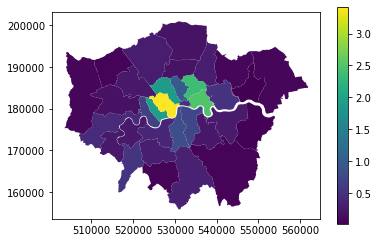

In [172]:
boros.plot(column = 'prop_airbnb', legend = True)

## Proxy 2: Proportion of Private Rent Earned by Airbnb Listings

### Airbnb data for 2021

Read data

In [173]:
# Load Airbnb data scraped on 10 Oct 2021
date_scraped = '20211010'
airbnb_2021 = load_airbnb(date_scraped)

Loading and cleaning Airbnb data for 20211010
67903 listings were loaded.
19238 listings were left after removing inactive listings.
12206 listings were left after keeping only entire home/apt listings.


/tmp/ipykernel_4517/27761743.py:32: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['price'] = df.price.str.replace('$','').str.replace(',','').astype(float)


Compute median Airbnb price

In [174]:
# Join Airbnb listings to boroughs
airbnb_2021_boros = gpd.sjoin(airbnb_2021, boros, op = 'within', how = 'left')

# Drop listings with no borough names (outside boroughs)
airbnb_2021_boros.drop(index=airbnb_2021_boros[airbnb_2021_boros.NAME.isnull()].index, axis=1, inplace=True)

# Compute median price for Airbnb for each borough
airbnb_price_2021 = airbnb_2021_boros.groupby('NAME').agg({"price": np.median}).reset_index()

# Join back to boros geodataframe
boros = boros.merge(airbnb_price_2021, on = 'NAME')

,id,latitude,longitude,room_type,price,minimum_nights,number_of_reviews_ltm,geometry,index_right,NAME,GSS_CODE,airbnb_income,rental_income,prop_airbnb
2,17402,51.521950,-0.14094,Entire home/apt,307.0,4,1,POINT (529075.790 181974.865),24,Westminster,E09000033,28704682.3,8.104377e+08,3.420716
7,36299,51.480850,-0.28086,Entire home/apt,195.0,3,4,POINT (519476.347 177167.001),19,Richmond upon Thames,E09000027,1450892.0,6.111619e+08,0.236837
23,43202,51.530310,-0.21713,Entire home/apt,130.0,4,4,POINT (523767.567 182773.008),8,Brent,E09000005,1655799.0,6.972315e+08,0.236919
32,47687,51.493400,-0.22929,Entire home/apt,78.0,2,1,POINT (523023.442 178647.953),22,Hammersmith and Fulham,E09000013,3676572.0,5.432929e+08,0.672171
37,56229,51.495470,-0.22942,Entire home/apt,45.0,5,6,POINT (523008.850 178877.928),22,Hammersmith and Fulham,E09000013,3676572.0,5.432929e+08,0.672171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67685,52615339,51.604481,0.03893,Entire home/apt,54.0,1,1,POINT (541297.910 191484.832),17,Redbridge,E09000026,316145.0,4.257926e+08,0.074193
67689,52616026,51.517130,-0.11178,Entire home/apt,759.0,3,1,POINT (531112.540 181490.662),32,City of London,E09000001,3832597.0,7.561624e+08,0.504292
67730,52629025,51.606280,-0.19845,Entire home/apt,65.0,5,1,POINT (524855.108 191253.023),9,Barnet,E09000003,895121.0,3.320100e+08,0.268882
67756,52644152,51.521250,-0.21100,Entire home/apt,180.0,1,1,POINT (524217.384 181775.869),23,Kensington and Chelsea,E09000020,10246865.0,5.218344e+08,1.925808


### Rental data for 2021

In [180]:
# Year
year = '2021'

# Dictionary for property type and sheet name
prop_sheet = {'studio': 'Table2.2',
              '1br': 'Table2.3',
              '2br': 'Table2.4',
              '3br': 'Table2.5',
              '4br': 'Table2.6'}

# Read data for each property type
for prop, sheet in prop_sheet.items():
    globals()['rental_' + prop] = load_rental(year, sheet)

In [181]:
# Compute average of median rental price, weighted by the count of rents

## Initialize dataframe
rental2021_median = rental_studio[['Area Code1', 'Area']]

## Add two columns - one to track total counts, one to track product of counts and median rental
rental2021_median = rental2021_median.reindex(columns = [*rental2021_median.columns.tolist(),
                                                         'Counts','Median'], fill_value = 0)

## Add counts, and product of counts and median rental, for all property types
for prop in prop_sheet.keys():
    ## Add counts
    rental2021_median.Counts = rental2021_median.Counts + globals()['rental_' + prop]['Count of rents']
    ## Add product of counts and median rental
    rental2021_median.Median = rental2021_median.Median + (
        (globals()['rental_' + prop]['Count of rents'] * globals()['rental_' + prop]['Median']))

## Compute average of median rent
rental2021_median.Median = rental2021_median.Median / rental2021_median.Counts

In [184]:
# Join median rent to boundaries
boros = boros.merge(rental2021_median, left_on = 'GSS_CODE', right_on = 'Area Code1')
boros.drop(columns = ['Area Code1', 'Area','Counts'], inplace = True)

### Compute and map proxy 2

In [201]:
boros['prop_price'] = (boros.price * 365 * 0.7) / (boros.Median * 12) * 100

<AxesSubplot:>

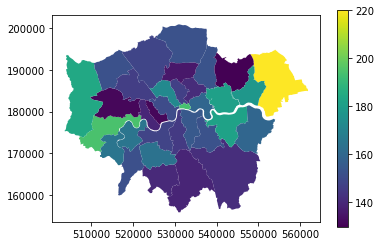

In [203]:
boros.plot(column = 'prop_price', legend = True)

## To do list
- sort boros
- make the computation of total Airbnb income and median Airbnb price into a function
- make the compuatation of median rental rate into a function
- standardize naming convention in boro gdf
- Investigate Havering